In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from numpy.linalg import cond, norm, inv
from scipy.spatial import cKDTree

import pandas as pd
from scipy.stats import linregress as linreg

import pickle
import os.path
import itertools

# import warnings
# warnings.simplefilter('ignore')

from poly_basis import *
from rbf import *
from spherepts import *
from laplacebeltrami import *

In [161]:
matplotlib.rcParams.update({'font.size': 16})

# Helpers

In [3]:
# look-up
def get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg):
    assert method in ['SWM', 'TPM']
    assert surface in ['S']
    if surface is 'S':
        assert node_set in ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
    assert poly_type in ['s', 'p']
    
    if method is 'TPM':
        poly_type = 'n'
    
    file_name  = 'pickles/'
    file_name += method
    file_name += ", " + surface
    file_name += ", " + node_set
    file_name += ", " + str(n)
    file_name += ", " + str(k)
    file_name += ", " + rbf_obj['label']
    file_name += ", " + str(epsilon)
    file_name += ", " + poly_type
    file_name += ", " + str(poly_deg)
    file_name += '.pickle'
    
    if os.path.isfile(file_name):
        f = open(file_name, 'rb')
        C = pickle.load(f)
        f.close()
    else:
        if method is 'SWM':
            C = SWM(nodes, normals, rbf_obj, epsilon, k, poly_deg, poly_type)
        elif method is 'TPM':
            C = TPM(nodes, normals, rbf_obj, epsilon, k, poly_deg)
        f = open(file_name, 'wb')
        pickle.dump(C, f)
        f.close()
            
    return C

In [4]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below
        harm_index = 20

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [5]:
def gen_sphere_nodes(node_set, n_try):
    if node_set == 'spiral':
        n = n_try
        nodes = gen_spiral_nodes(n)
    elif node_set == 'sym_t_design':
        n, nodes = gen_symmetric_t_design_nodes(n_try)
    elif node_set == 'min_energy':
        n, nodes = gen_min_energy_nodes(n_try)
    elif node_set == 'max_det':
        n, nodes = gen_max_det_nodes(n_try)
    elif node_set == 'icos':
        n, nodes = gen_equ_area_icos_nodes(n_try)
    
    return n, nodes

# Testing

In [23]:
method = 'SWM'
surface = 'S'
n = 800
k = 50
rbf_obj = rbf_dict['r^9']
epsilon = None
poly_type = 'p'
poly_deg = 3

foo, exact = get_exact('gaussians')

node_set = 'spiral'
nodes = gen_spiral_nodes(n)
normals = nodes



C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg)
print(C.todense())

[[-287.00406618   46.30719769   61.63264702 ...    0.
     0.            0.        ]
 [  48.44107006 -273.53841604   24.70155784 ...    0.
     0.            0.        ]
 [  48.80485246   30.89049866 -259.96038915 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -259.96038916
    30.89049865   48.80485246]
 [   0.            0.            0.         ...   24.70155784
  -273.53841603   48.44107005]
 [   0.            0.            0.         ...   61.63264701
    46.30719768 -287.00406618]]


In [24]:
fs = np.array([foo(node) for node in nodes])
ds = np.array([exact(node) for node in nodes])
print(np.max(np.abs(C@fs - ds)))

0.020642777718977934


# Parameters

In [215]:
surface = 'S'

methods = ['SWM', 'TPM']
# methods = ['SWM']

#node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
node_sets = ['spiral']

ns = [100* 2**i for i in range(0,7)]
#ns = [400]

stencil_sizes = [50]

#rbfs = ['gaussian', 'r^9']
rbfs = ['r^9']

epsilons = [None]
#epsilons = [1, .5, .25, .1, .05]

#basis_degs = [1, 2] # -1 for no terms
basis_degs = range(-1,4) # -1 for no terms
#basis_types = ['p', 's']
basis_types = ['p', 's']

foo, exact = get_exact('gaussians')
# foo, exact = get_exact(10)


# calculate_weights_cond = False
# calculate_stencil_conds = True
# calc_largest_real_eig = True 


# Print Specs
sep = 22
print('Methods:'.ljust(sep)            + ', '.join(methods))
print('Surface:'.ljust(sep)            + surface)
print('Node sets:'.ljust(sep)          + ', '.join(node_sets))
print('Total Nodes:'.ljust(sep)        + ', '.join([str(n) for n in ns]))
print('Stencil Sizes:'.ljust(sep)      + ', '.join([str(k) for k in stencil_sizes]))
print('RBFs:'.ljust(sep)               + ', '.join(rbfs))
print('Epsilons:'.ljust(sep)           + ', '.join([str(e) for e in epsilons]) )
print('Polynomial Bases:'.ljust(sep)   + ', '.join(basis_types))
print('Polynomial Degrees:'.ljust(sep) + ', '.join([str(d) for d in basis_degs]))

trials = 1
trials *= len(methods)
trials *= len(node_sets)
trials *= len(ns)
trials *= len(stencil_sizes)
trials *= len(rbfs)
trials *= len(epsilons)
trials *= len(basis_types)
trials *= len(basis_degs)

print('\nTrials to run: %d' % trials)

Methods:              SWM, TPM
Surface:              S
Node sets:            spiral
Total Nodes:          100, 200, 400, 800, 1600, 3200, 6400
Stencil Sizes:        50
RBFs:                 r^9
Epsilons:             None
Polynomial Bases:     p, s
Polynomial Degrees:   -1, 0, 1, 2, 3

Trials to run: 140


# Generate Data

In [216]:
columns = ['surface', 'nodeset', 'N', 'k', 'method', 'rbf', 'epsilon', 'poly_type', 'deg',
           'rel_L2_error', 'max_error']
# , 're_eig', 'cond', 'skeel', 'stencil_cond'
data = pd.DataFrame(columns=columns)

for node_set, n in itertools.product(node_sets, ns):
    print('\n' + node_set + ' n=' + str(n))
    if surface is 'S':
        n_try = n
        n, nodes = gen_sphere_nodes(node_set, n_try)
        normals = nodes
    fs = np.array([foo(node) for node in nodes])
    ds = np.array([exact(node) for node in nodes])
    tree = cKDTree(np.array(nodes))
    for k, rbf in itertools.product(stencil_sizes, rbfs):
        print(('\t' + rbf.ljust(10)) + 'k=' + str(k).rjust(4))
        rbf_obj = rbf_dict[rbf]
        
        for method in methods:
            for poly_type, poly_deg in itertools.product(basis_types, basis_degs):
                if method is 'TPM' and poly_type is 's': continue
                print('\t    ' + method +'  ' + poly_type + '  d=' + str(poly_deg).rjust(2))
                for eps in epsilons:
                    if rbf_obj['shape']:
                        print('\t\t epsilon = %s' % str(eps))
                    ##################################################
                    # calculate weights and errors
                    ##############################
                    if poly_deg is -1:
                        poly_deg = None
                    try:
                    if True:
                        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                                    eps, poly_type, poly_deg)
                        rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
                        rel_error_max = np.max(np.abs(C@fs - ds))
                        print('\t\t  relative L2  error: %g' % rel_error_L2)
                        print('\t\t  relative Max error: %g' % rel_error_max)
                        data = data.append( 
                            {'method': method, 'surface': surface,
                             'nodeset': node_set, 'rbf':rbf, 'epsilon': epsilon,
                             'deg': str(poly_deg), 'poly_type' : poly_type,
                             'N':n, 'k':k,
                             'max_error': rel_error_max, 
                             'rel_L2_error': rel_error_L2,
                             }, ignore_index=True)
                    except:
                        print('\t\t  Failed...')
                    
                    
                    ##################################################
                    # end calculate weights and errors
                    ##################################################
                    if not rbf_obj['shape']: break
    


spiral n=100
	r^9       k=  50
	    SWM  p  d= -1
		  relative L2  error: 0.125306
		  relative Max error: 2.65366
	    SWM  p  d=  0
		  relative L2  error: 0.121784
		  relative Max error: 2.5443
	    SWM  p  d=  1
		  relative L2  error: 0.142602
		  relative Max error: 2.55574
	    SWM  p  d=  2
		  relative L2  error: 0.122685
		  relative Max error: 2.55474
	    SWM  p  d=  3
		  relative L2  error: 0.163836
		  relative Max error: 2.84827
	    SWM  s  d= -1
		  relative L2  error: 0.125306
		  relative Max error: 2.65366
	    SWM  s  d=  0
		  relative L2  error: 0.121784
		  relative Max error: 2.5443
	    SWM  s  d=  1
		  relative L2  error: 0.142602
		  relative Max error: 2.55574
	    SWM  s  d=  2
		  relative L2  error: 0.122685
		  relative Max error: 2.55474
	    SWM  s  d=  3
		  relative L2  error: 0.163836
		  relative Max error: 2.84827
	    TPM  p  d= -1
		  relative L2  error: 0.510198
		  relative Max error: 3.4025
	    TPM  p  d=  0
		  relative L2  error: 0.05

		  relative L2  error: 0.000106516
		  relative Max error: 0.00200819
	    SWM  p  d=  3
		  relative L2  error: 4.72763e-05
		  relative Max error: 0.000839476
	    SWM  s  d= -1
		  relative L2  error: 4.89672
		  relative Max error: 70.0691
	    SWM  s  d=  0
		  relative L2  error: 0.0262925
		  relative Max error: 1.13429
	    SWM  s  d=  1
		  relative L2  error: 0.000752715
		  relative Max error: 0.0130718
	    SWM  s  d=  2
		  relative L2  error: 0.000106516
		  relative Max error: 0.00200819
	    SWM  s  d=  3
		  relative L2  error: 4.72763e-05
		  relative Max error: 0.000839543
	    TPM  p  d= -1
		  relative L2  error: 1.83841
		  relative Max error: 70.1845
	    TPM  p  d=  0
		  relative L2  error: 0.0119968
		  relative Max error: 0.521805
	    TPM  p  d=  1
		  relative L2  error: 0.00089957
		  relative Max error: 0.027751
	    TPM  p  d=  2
		  relative L2  error: 7.24047e-05
		  relative Max error: 0.00125327
	    TPM  p  d=  3
		  relative L2  error: 3.09487e-05

In [225]:
if len(data)<20:
    display(data)
elif len(data)< 100:
    display(data[::7])
elif len(data)< 500:
    display(data[::11])
elif len(data)<1000:
    display(data[::51])
else:
    display(data[:5000:100])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error
0,S,spiral,100,50,SWM,r^9,None,p,None,0.125306,2.653660
11,S,spiral,100,50,TPM,r^9,None,p,0,0.055142,0.546766
22,S,spiral,200,50,SWM,r^9,None,s,1,0.021283,0.360535
33,S,spiral,400,50,SWM,r^9,None,p,2,34.993947,2158.137251
44,S,spiral,400,50,TPM,r^9,None,p,3,0.001954,0.027166
55,S,spiral,800,50,TPM,r^9,None,p,None,0.551161,11.256889
66,S,spiral,1600,50,SWM,r^9,None,s,0,0.017025,0.410069
77,S,spiral,3200,50,SWM,r^9,None,p,1,0.001117,0.018373
88,S,spiral,3200,50,TPM,r^9,None,p,2,0.000129,0.001728
99,S,spiral,6400,50,SWM,r^9,None,s,3,0.000047,0.000840


# Plots

### By Degree - (Method, RBF, polytype, k)

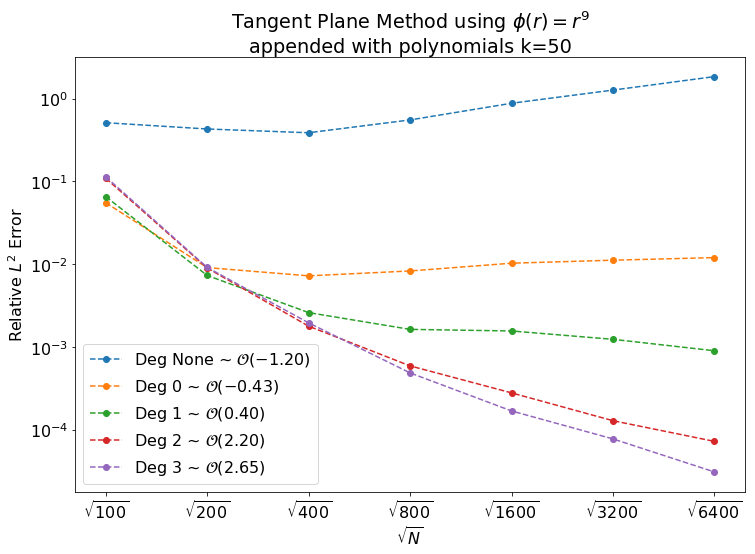

In [234]:
rbf = 'r^9'
method = 'TPM'
poly_type = 'p'
k = 50

# Order calculation terms
o_start = 3
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
if method is 'SWM':
    title += 'Shankar-Wright Method using '
elif method is 'TPM':
    title += 'Tangent Plane Method using '
rbf_obj = rbf_dict[rbf]
title += '$\phi(r)=$' + rbf_obj['tex']
if poly_type is 'p':
    title += '\nappended with polynomials '
else:
    title += '\nappended with spherical harmonics '
title += ('k=%d' % k)

my_data = data[(data.method==method) & (data.rbf==rbf) & (data.poly_type==poly_type)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, deg in enumerate(my_data.deg.unique()):
    plot_data = my_data[my_data.deg==str(deg)]
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += ['Deg ' + deg + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Method - (RBF, d, k)

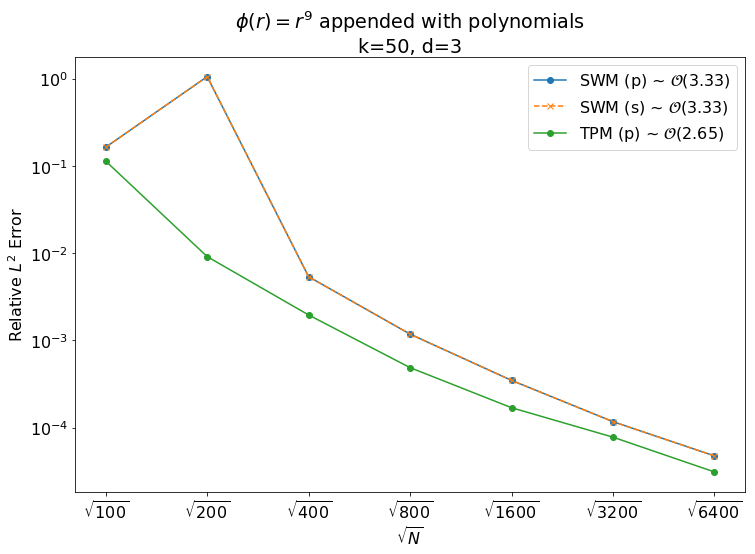

In [239]:
rbf = 'r^9'
#poly_type = 'p'
d = '3'
k = 50

# Order calculation terms
o_start = 3
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.rbf==rbf)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, method in enumerate(my_data.method.unique()):
    for poly_type, linestyle, marker in zip('ps', ['-','--'], 'ox'):
        plot_data = my_data[(my_data.method==method) & (my_data.poly_type==poly_type)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()